Import External Libraries

In [53]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from pathlib import Path
import yaml

Import Filter and Model Code

In [ ]:
from models.equation import Solver1D
from models.init_cond import get_initial_condition
from filters import resamplers
from filters.filter import ParticleFilter
import metrics.ensemble as ens_metrics


In [55]:
config_path = Path('config/')
config_files = list(config_path.glob('**/*.yaml'))
print('Available config files:')
for i, f in enumerate(config_files):
    config_avail = {f.name: f for i, f in enumerate(config_files)}
for key, value in config_avail.items():
    print(f"{key}: {value}")

Available config files:
config.yaml: config/config.yaml
filter.yaml: config/filter/filter.yaml
Burgers.yaml: config/model/Burgers.yaml
HeatEquation.yaml: config/model/HeatEquation.yaml
Korteweg-de-Vries.yaml: config/model/Korteweg-de-Vries.yaml
Kuramoto-Sivashinsky.yaml: config/model/Kuramoto-Sivashinsky.yaml
KdV_det.yaml: config/model/KdV_det.yaml
KdV_SALT.yaml: config/model/KdV_SALT.yaml


In [56]:
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [57]:
KDV_params = yaml.load(open(config_avail['KdV_det.yaml']), Loader=yaml.FullLoader)
print(KDV_params)
signal_params = ConfigDict(KDV_params)

print(signal_params)

{'equation_name': 'KdV', 'c_0': 0, 'c_1': 1, 'c_2': 0.0, 'c_3': 2e-05, 'c_4': 0.0, 'xmin': 0, 'xmax': 1, 'nx': 256, 'P': 1, 'S': 0, 'E': 1, 'tmax': 1, 'dt': 0.001, 'noise_magnitude': 0.0, 'initial_condition': 'gaussian', 'method': 'Dealiased_SETDRK4', 'Advection_basis_name': 'none', 'Forcing_basis_name': 'none'}
Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.0
nx: 256
tmax: 1
xmax: 1
xmin: 0



In [58]:
KDV_SALT = yaml.load(open(config_avail['KdV_SALT.yaml']), Loader=yaml.FullLoader)
ensemble_params = ConfigDict(KDV_SALT)
print(ensemble_params)

Advection_basis_name: constant
E: 10
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.01
nx: 256
tmax: 1
xmax: 1
xmin: 0



In [59]:
signal_params.update(E=1,method='Dealiased_ETDRK4',P=1,S=0,tmax=4,nmax=256*4)
ensemble_params.update(E=128,noise_magnitude=0.001,P=32,tmax=4,nmax=256*4)

In [ ]:
signal_model_1 = Solver1D(signal_params)
signal_model_2 = Solver1D(signal_params)
signal_model_3 = Solver1D(signal_params)

ensemble_model_1 = Solver1D(ensemble_params)
ensemble_model_2 = Solver1D(ensemble_params)
ensemble_model_3 = Solver1D(ensemble_params)

initial_signal = get_initial_condition(signal_model_1.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = get_initial_condition(ensemble_model_1.x, ensemble_params.E, ensemble_params.initial_condition)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

multinomial, systematic, no_resampling, default


In [61]:
obs_frequency = 32
observation_noise = 1e-2
observation_locations_params = jnp.arange(0,len(signal_model_1.x),obs_frequency)
#observation_locations_params = None
pf_multinomial = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_1,
    signal_model = signal_model_1,
    sigma = observation_noise,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='multinomial',
    observation_locations = observation_locations_params,
)

pf_systematic = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_2,
    signal_model = signal_model_2,
    sigma = observation_noise,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='systematic',
    observation_locations = observation_locations_params,
)

pf_no_resampling = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_3,
    signal_model = signal_model_3,
    sigma = observation_noise,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='no_resampling',
    observation_locations = observation_locations_params,
)

In [62]:
final_systematic, all_systematic = pf_systematic.run(initial_ensemble, initial_signal, signal_model_1.nmax) 
final_multinomial, all_multinomial = pf_multinomial.run(initial_ensemble, initial_signal, signal_model_1.nmax) 
final_no_resampling, all_no_resampling = pf_no_resampling.run(initial_ensemble, initial_signal, signal_model_1.nmax)
print(all_systematic[2].shape)

(4000, 1, 256)


In [63]:
print(all_systematic[0].shape,all_systematic[1].shape,all_systematic[2].shape)
# ensemble, signal, observation

(4000, 128, 256) (4000, 1, 256) (4000, 1, 256)


Put in the initial condition.

In [64]:
particles_systematic = jnp.concatenate([initial_ensemble[None,...], all_systematic[0]], axis=0)
particles_multinomial = jnp.concatenate([initial_ensemble[None,...], all_multinomial[0]], axis=0)
particles_no_resampling = jnp.concatenate([initial_ensemble[None,...], all_no_resampling[0]], axis=0)

signal = jnp.concatenate([initial_signal[None,...], all_systematic[1]], axis=0)
print(f"Particles Shape: {particles_systematic.shape} is (N_da_steps+1, N_particles, N_dim)")
print(f"Signal Shape: {signal.shape} is (N_da_steps+1, 1,  N_dim)")
observations = all_systematic[2]
print(f"Observations Shape: {observations.shape} is (N_da_steps, 1,  N_dim)")
print(f"needs fixing, this should be (N_da_steps, N_obs_dim, N_dim)")

Particles Shape: (4001, 128, 256) is (N_da_steps+1, N_particles, N_dim)
Signal Shape: (4001, 1, 256) is (N_da_steps+1, 1,  N_dim)
Observations Shape: (4000, 1, 256) is (N_da_steps, 1,  N_dim)
needs fixing, this should be (N_da_steps, N_obs_dim, N_dim)


In [65]:
def plot(da_step):
    plt.plot(signal_model_1.x, signal[da_step,0,:], color='k',label='signal')
    
    plt.plot(signal_model_1.x, particles_systematic[da_step,:,:].T, color='b',linewidth=0.01)
    plt.plot(signal_model_1.x, particles_systematic[da_step,0,:].T, color='b',label='systematic',linewidth=0.01)

    plt.plot(signal_model_1.x, particles_no_resampling[da_step,:,:].T, color='r',linewidth=0.01)
    plt.plot(signal_model_1.x, particles_no_resampling[da_step,0,:].T, color='r',label='no resampling',linewidth=0.01)
    
    plt.scatter(signal_model_1.x[::obs_frequency], observations[da_step,0,::obs_frequency], color='r',label='observations')
    plt.legend()
    plt.show()

interact(plot, da_step=(0, signal_model_1.nmax))

interactive(children=(IntSlider(value=2000, description='da_step', max=4000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

In [ ]:
bias_systematic = ens_metrics.bias(signal[1:,...], particles_systematic[1:,...])
rmse_systematic = ens_metrics.rmse(signal[1:,...], particles_systematic[1:,...])
crps_systematic = ens_metrics.crps(signal[1:,...], particles_systematic[1:,...])
bias_multinomial = ens_metrics.bias(signal[1:,...], particles_multinomial[1:,...])
rmse_multinomial = ens_metrics.rmse(signal[1:,...], particles_multinomial[1:,...])
crps_multinomial = ens_metrics.crps(signal[1:,...], particles_multinomial[1:,...])
bias_no_resampling = ens_metrics.bias(signal[1:,...], particles_no_resampling[1:,...])
rmse_no_resampling = ens_metrics.rmse(signal[1:,...], particles_no_resampling[1:,...])
crps_no_resampling = ens_metrics.crps(signal[1:,...], particles_no_resampling[1:,...])

In [ ]:
print(bias_systematic.shape, rmse_systematic.shape, crps_systematic.shape)

NameError: name 'bias_systematic' is not defined

In [ ]:
plt.title('RMSE')
plt.plot(rmse_systematic,label=f'systematic-resampling',c='r')
plt.plot(rmse_multinomial,label=f'multinomial-resampling',c='b')
plt.plot(rmse_no_resampling,label=f'no-resampling',c='g')
plt.plot(observation_noise*jnp.ones_like(rmse_systematic),label=f'observation noise magnitude',c='k')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

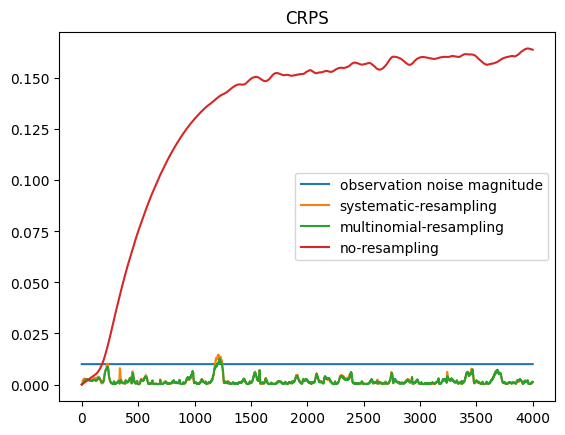

In [ ]:
plt.title('CRPS')
plt.plot(observation_noise*jnp.ones_like(crps_systematic),label=f'observation noise magnitude')
plt.plot(crps_systematic,label=f'systematic-resampling')
plt.plot(crps_multinomial,label=f'multinomial-resampling')
plt.plot(crps_no_resampling,label=f'no-resampling')
plt.legend()
plt.show()